## Experiment 1:
Experiment 1: SVM using the 20 sampled data points without enhancements

In [1]:
# All modules:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn import svm
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from scipy.spatial import distance
import math
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn_extra.cluster import KMedoids
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import AgglomerativeClustering
import random

## Functions:

In [2]:
# Purpose of function is to classify only k nearest points to the training dataset:
def knnclassify_nearestk2(dataset, training, labels, k, fault):
    closest_k = []
    for i in range(len(training)):
        distances = []
        for u in range(len(dataset)):
            if u not in dataset:
                distances.append(distance.cityblock(training.iloc[i,:],dataset.iloc[u,0:24]))
            else:
                continue
#         distances = [f for f in distances if f != 0]
        distances_ = sorted(range(len(distances)), key = lambda sub: distances[sub])[:k]
        # Labeling
        dataset.loc[distances_,fault] = labels.iloc[i][0]
#                 distances_ = np.argpartition(distances,k)[:k]
        closest_k.append(distances_)
    # Try np.ravel, flattening
    closest_k_p = list(itertools.chain.from_iterable(closest_k))
    return dataset.iloc[closest_k_p,:]

In [4]:
# Purpose of function is to classify only k nearest points to the training dataset:

def knnclassify_nearestk(dataset, training, labels, k, clus_num, lab_clus_ind):
    closest_k = []
    for i in range(len(training)):
        distances = []
        for u in range(len(dataset)):
            if u not in lab_clus_ind[clus_num]:
                distances.append(distance.cityblock(training.iloc[i,:],dataset.iloc[u,:]))
            else:
                continue
#         distances = [f for f in distances if f != 0]
        distances_ = sorted(range(len(distances)), key = lambda sub: distances[sub])[:k+1]
        # Labeling
        dataset.iloc[distances_,0] = labels.iloc[i]
#                 distances_ = np.argpartition(distances,k)[:k]
        closest_k.append(distances_)
    # Try np.ravel, flattening
    closest_k_p = list(itertools.chain.from_iterable(closest_k))
    return dataset.iloc[closest_k_p,:]

In [5]:
def sampling(new_df, fault, num_sam, corr_list):
#     sample = new_df.groupby(fault).apply(lambda x: x.sample(num_sam))
    sample = new_df.sample(n = num_sam)
    x_train = sample.drop(['No Fault', 'Evaporator Fault', 'Condenser Fault' ,'Undercharged B', 'Overcharged A'], axis = 1)
    x_train = x_train.loc[:,corr_list]
    y_train = sample.loc[:,['No Fault', 'Evaporator Fault', 'Condenser Fault' ,'Undercharged B', 'Overcharged A']]
    y_train = y_train.loc[:,~y_train.columns.duplicated()]
    inds = [r[1] for r in sample.index]
    return sample, x_train, y_train, inds

In [6]:
# clusters_ind[0]
# com_clus_inds = list(itertools.chain.from_iterable(clusters_ind))
# X_nso.iloc[com_clus_inds,:]
def knn_by_cluster(cluster_data, lab_clus_ind, k):
    train_cluster = []
    for i in range(len(cluster_data)):
        train_cluster.append(knnclassify_nearestk(cluster_data[i], X_nso.iloc[lab_clus_ind[i],:], y_nso[lab_clus_ind[i]], k, i, lab_clus_ind))
    train_cluster = pd.concat(train_cluster, axis = 0)
    return train_cluster

In [7]:
def SVM_model(fault, new_df, x_train, y_train, inds, df_corr_list):
    
    x_test = df_corr_list.iloc[:,0:24]
    y_test = new_df.loc[:,['No Fault', 'Evaporator Fault', 'Condenser Fault' ,'Undercharged B', 'Overcharged A']]

    x_test = x_test.drop(inds, axis= 0)
    y_test = y_test.drop(inds, axis= 0)

    y_train = y_train.loc[:,fault]
    y_test = y_test.loc[:,fault]

    model = svm.SVC(kernel='linear', C = 1.22, class_weight = 'balanced')# Linear Kernel
    # evaluate model and report performance
    # scaler = preprocessing.StandardScaler()
    # max_abs_scaler = preprocessing.MaxAbsScaler()
    quantile_transformer = preprocessing.QuantileTransformer(n_quantiles = x_train.shape[0], random_state=0)
    # normalizer = preprocessing.Normalizer()
    # pt = preprocessing.PowerTransformer('yeo-johnson', standardize=False)

    x_train = quantile_transformer.fit_transform(x_train)
    x_test = quantile_transformer.transform(x_test)
    
    model.fit(x_train, y_train)
    pred_svm = model.predict(x_test)
    
    acc = accuracy_score(y_test, pred_svm)
    
    return acc, x_train, y_train, x_test, y_test
    

In [8]:
vals = [1,25,50,75,100]
def plt_knn_alon(vals, new_df, x_train, y_train, sample, corr_list, fault, inds):
    acc = []
    train = []
    for i in vals:
        new_training3 = knnclassify_nearestk2(new_df.loc[:,corr_list], x_train, y_train, i, fault)
        new_training_2 = pd.concat([sample, new_training3], axis = 0)
        new_train3 = list(set(new_training3.index)) + inds 
        new_df_corr = new_df.loc[:,corr_list[0:24]]
        x_trainrj3 = new_df_corr.iloc[new_train3,:]
        # x_trainrj3 = x_trainrj3.loc[:,corr_list[0:24]]
        y_trainrj3 = new_df.loc[new_train3, fault]
        x_testrj3 = new_df_corr.drop(new_df_corr.iloc[new_train3,:].index)
        # x_testrj3 = x_testrj3.loc[:,corr_list[0:24]]
        y_testrj3 = new_df.drop(new_df.loc[new_train3,fault].index)
        y_testrj3 = y_testrj3.loc[:,fault]
        model = svm.SVC(kernel='poly', C = 1.22, degree = 5)# Linear Kernel
        # evaluate model and report performance
        # scaler = preprocessing.StandardScaler()
        # max_abs_scaler = preprocessing.MaxAbsScaler()
        quantile_transformer = preprocessing.QuantileTransformer(n_quantiles = x_trainrj3.shape[0], random_state=0)
        # # normalizer = preprocessing.Normalizer()
        # # pt = preprocessing.PowerTransformer('yeo-johnson', standardize=False)
        x_trainrj3 = quantile_transformer.fit_transform(x_trainrj3)
        x_testrj3 = quantile_transformer.transform(x_testrj3)
        model.fit(x_trainrj3, y_trainrj3)
        pred_svmrj3 = model.predict(x_testrj3)

        acc.append(accuracy_score(pred_svmrj3, y_testrj3))
        train.append(len(new_training_2))
        
    plot1 = plt.plot(vals, acc,'bo')
    plt.plot(vals, acc, 'r')
    plt.xlabel('# of K')
    plt.ylabel('Accuracy (%)')
    plt.title('# of K vs. Accuracy (k-NN)')
#         plot2 = plt.plot(train, acc,'ko')
#         plt.plot(train, acc, 'g')
#         plt.xlabel('Training set size')
#         plt.ylabel('Accuracy (%)')
#         plt.title('Training set size vs. Accuracy')
    return plot1

# Binary Classification:

In [10]:
new_df = pd.read_csv('New Dataset with one-hot.csv').drop('Unnamed: 0', axis = 1)
# alldays_labels_
# new_df.loc[:,'Evaporator Fault'].value_counts()
import pickle
with open('column_names.pkl', 'rb') as f:
   unpickler = pickle.Unpickler(f)
   corr_list = unpickler.load()
# corr_list = corr_list + ['No Fault', 'Evaporator Fault', 'Condenser Fault', 'Condenser Fault' ,'Undercharged B', 'Overcharged A', 'System Off']
new_df
new_df_corr = new_df.loc[:,corr_list]

In [11]:
new_df = new_df.drop('System Off', axis = 1)

In [16]:
new_df.loc[:,'No Fault'].value_counts()

0.0    3163
1.0     173
Name: No Fault, dtype: int64

In [17]:
new_df.loc[:,'Evaporator Fault'].value_counts()

0.0    2725
1.0     611
Name: Evaporator Fault, dtype: int64

In [19]:
new_df.loc[:,'Condenser Fault'].value_counts()

1.0    2022
0.0    1314
Name: Condenser Fault, dtype: int64

In [20]:
new_df.loc[:,'Undercharged B'].value_counts()

0.0    1750
1.0    1586
Name: Undercharged B, dtype: int64

In [21]:
new_df.loc[:,'Overcharged A'].value_counts()

0.0    2296
1.0    1040
Name: Overcharged A, dtype: int64

# k-Medoids Clustering:

In [71]:
sample_data = new_df.sample(n = math.floor(new_df.shape[0]/110))#X_nso.shape[0]/150)
labels2 = sample_data.loc[:,['No Fault', 'Evaporator Fault', 'Condenser Fault' ,'Undercharged B', 'Overcharged A']]
data2 = sample_data.drop(['No Fault', 'Evaporator Fault', 'Condenser Fault' ,'Undercharged B', 'Overcharged A'], axis = 1)
# organize labeled data by cluster:
lab_clus_ind2 = []
act_labels2 = set(labels2)
for i in act_labels2:
    cond = (labels2 == 1)
    lab_clus_ind2.append(np.where(cond)[0])
# clus_ind = list(itertools.chain.from_iterable(clus_ind))
len(lab_clus_ind2)
lab_clus_ind2
kmediods = KMedoids(5, 'manhattan', init = 'heuristic').fit(new_df.iloc[:,0:24])
# seperating cluster to apply KNN
clusters_ind2 = []
for i in range(len(set(kmediods.labels_))):
    cond = (kmediods.labels_ == i)
    clusters_ind2.append(np.where(cond)[0])
if len(lab_clus_ind2) == 5:
    print("All Clusters are Sampled")
else:
    print("Not All Clusters are Sampled")

All Clusters are Sampled


/Users/jalalfaraj/opt/anaconda3/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/Users/jalalfaraj/opt/anaconda3/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(


In [94]:
data2.index[0]

1906

In [100]:
lab_clus_ind2 = []
for i in range(len(data2)):
    ind = data2.index[i]
    for g in range(len(clusters_ind2)):
        if ind in clusters_ind2[g]:
            lab_clus_ind2.append(g)  

# Evaporator Fault:

In [27]:
sample_ef = sampling(new_df, 'Evaporator Fault', 5, corr_list)

## SVM:

In [28]:
acc_ef = SVM_model('Evaporator Fault', new_df, sample_ef[1], sample_ef[2], sample_ef[3], new_df_corr)
acc_ef[0]

0.9675285628382442

## k-NN + SVM:

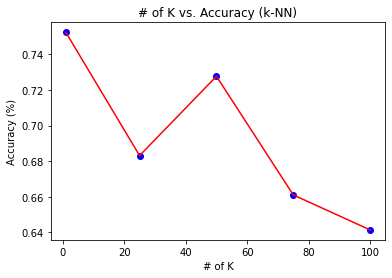

In [29]:
# def plt_knn_alon(vals, new_df, x_train, y_train, sample, corr_list, fault):
x_train = pd.DataFrame(acc_ef[1])
y_train = pd.DataFrame(acc_ef[2])
# x_test = pd.DataFrame(acc_cf[3])
# y_test = pd.DataFrame(acc_cf[4])
plt_knn_alon(vals, new_df, x_train, y_train, sample_ef[0], corr_list, 'Evaporator Fault', sample_ef[3])

# No Fault:

In [30]:
sample_nf = sampling(new_df, 'No Fault', 5, corr_list)

## SVM:

In [31]:
acc_nf = SVM_model('No Fault', new_df, sample_nf[1], sample_nf[2], sample_nf[3], new_df_corr)
acc_nf[0]

0.7570655441972339

## k-NN +SVM:

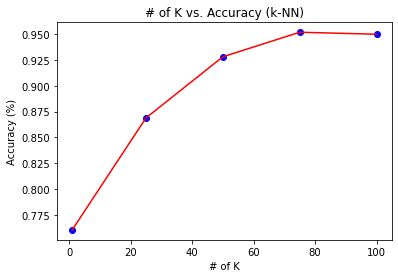

In [32]:
# def plt_knn_alon(vals, new_df, x_train, y_train, sample, corr_list, fault):
x_train = pd.DataFrame(acc_nf[1])
y_train = pd.DataFrame(acc_nf[2])
# x_test = pd.DataFrame(acc_cf[3])
# y_test = pd.DataFrame(acc_cf[4])
plt_knn_alon(vals, new_df, x_train, y_train, sample_nf[0], corr_list, 'No Fault', sample_nf[3])

# Condenser Fault:

In [33]:
sample_cf = sampling(new_df, 'Condenser Fault', 5, corr_list)

## SVM:

In [34]:
# def SVM_model(fault, new_df, x_train, y_train, inds):
acc_cf = SVM_model('Condenser Fault', new_df, sample_cf[1], sample_cf[2], sample_cf[3], new_df_corr)
acc_cf[0]

0.9263379434756465

## k-NN + SVM:

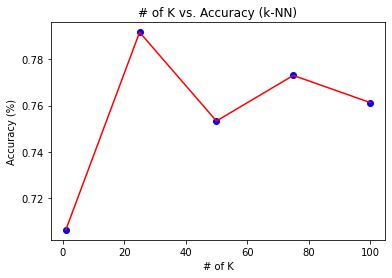

In [35]:
# def plt_knn_alon(vals, new_df, x_train, y_train, sample, corr_list, fault):
x_train = pd.DataFrame(acc_cf[1])
y_train = pd.DataFrame(acc_cf[2])
# x_test = pd.DataFrame(acc_cf[3])
# y_test = pd.DataFrame(acc_cf[4])
plt_knn_alon(vals, new_df, x_train, y_train, sample_cf[0], corr_list, 'Condenser Fault', sample_cf[3])

# Undercharged B:

In [36]:
sample_UB = sampling(new_df, 'Undercharged B', 5, corr_list)
# [0] = sampled dataset; [1] = x_train; [2] = y_train, [3] = inds

## SVM:

In [37]:
# def SVM_model(fault, new_df, x_train, y_train, inds):
acc_UB = SVM_model('Undercharged B', new_df, sample_UB[1], sample_UB[2], sample_UB[3], new_df_corr)
acc_UB[0]

0.9031870114251352

## k-NN + SVM:

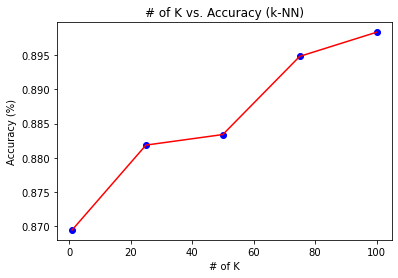

In [38]:
# def plt_knn_alon(vals, new_df, x_train, y_train, sample, corr_list, fault):
x_train = pd.DataFrame(acc_UB[1])
y_train = pd.DataFrame(acc_UB[2])
# x_test = pd.DataFrame(acc_cf[3])
# y_test = pd.DataFrame(acc_cf[4])
plt_knn_alon(vals, new_df, x_train, y_train, sample_UB[0], corr_list, 'Undercharged B', sample_UB[3])

# Overcharged A:

In [39]:
sample_OA = sampling(new_df, 'Overcharged A', 5, corr_list)
# [0] = sampled dataset; [1] = x_train; [2] = y_train, [3] = inds

## SVM:

In [40]:
# def SVM_model(fault, new_df, x_train, y_train, inds):
acc_OA = SVM_model('Overcharged A', new_df, sample_OA[1], sample_OA[2], sample_OA[3], new_df_corr)
acc_OA[0]

0.9512928442573662

## k-NN + SVM:

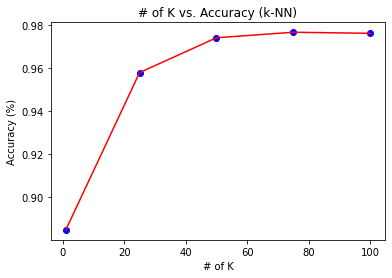

In [41]:
# def plt_knn_alon(vals, new_df, x_train, y_train, sample, corr_list, fault):
x_train = pd.DataFrame(acc_OA[1])
y_train = pd.DataFrame(acc_OA[2])
# x_test = pd.DataFrame(acc_cf[3])
# y_test = pd.DataFrame(acc_cf[4])
plt_knn_alon(vals, new_df, x_train, y_train, sample_OA[0], corr_list, 'Overcharged A', sample_OA[3])